# TensorFlow lab 2: MNIST with softmax regression

MNIST is a dataset of grayscale images of handwritten digits, released by the National Institute of Standards and Technology.

I'll give you the code to build a softmax regression model, but feel free to throw something more interesting in there.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

import sklearn.decomposition
from tensorflow.contrib import slim

%matplotlib inline
from IPython.core.pylabtools import figsize

In [2]:
tf.__version__

'1.3.0'

## Load the dataset

TensorFlow comes with some convenience functions for loading the train and test sets.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

Edit the `"data/"` to wherever you hid the files.

In [4]:
mnist = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [5]:
mnist.train

The images in the dataset are 28x28 pixels. When we load them we'll get an Nx784 matrix of unravelled images.

In [6]:
mnist.train.images.shape

(55000, 784)

The labels will be an array of numbers between 0 and 9:

In [7]:
mnist.train.labels.shape

(55000,)

In [8]:
mnist.train.labels[:10]

array([7, 3, 4, 6, 1, 8, 1, 0, 9, 8], dtype=uint8)

In [9]:
mnist.test.images.shape

(10000, 784)

In [10]:
accs = {}
weightdiffs = {}

In [36]:
modelname = "sigmoid"

x = tf.placeholder(tf.float32, [None, 784], name="data_placeholder")
y_ = tf.placeholder(tf.int32, [None,], name="label_placeholder")

y_oh = tf.one_hot(y_, 10, name="labels_one_hot")

net = tf.reshape(x, [-1, 28, 28,1])
for i in range(3):
    #net = slim.conv2d(net, 10, [3,3], activation_fn=tf.nn.relu)
    net = slim.conv2d(net, 10, [3,3], activation_fn=tf.nn.sigmoid)
    net = slim.max_pool2d(net, [2,2], stride=[2,2])
flattened = slim.flatten(net)
y = slim.linear(flattened, 10)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=y))

learnrate = 0.1

optimizer = tf.train.GradientDescentOptimizer(learnrate)
train_step = optimizer.minimize(cross_entropy)

prediction = tf.argmax(y,1)
correct_prediction = tf.equal(prediction, tf.argmax(y_oh,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [37]:
# find all the weight matrices:
weight_vars = [x for x in tf.global_variables() if "weights" in x.name]
weight_names = [x.name for x in weight_vars]
weightdiffs[modelname] = {x:[] for x in weight_names}

## Train the model

In [38]:
numsteps = 100
# create an empty array to hold test accuracy at each step
#test_acc = np.zeros(numsteps)
accs[modelname] = np.zeros(numsteps)

test_batchsize = 10000 # make sure it's an integer multiple of
                        # the number of test examples
num_test_batches = int(len(mnist.test.labels)/test_batchsize)

# create a session to run in
with tf.Session() as sess:
    # initialize variables
    tf.global_variables_initializer().run()
    # for each training step
    for i in tqdm(range(numsteps)):
        # pull the next batch of images and labels
        batch_xs, batch_ys = mnist.train.next_batch(100)
        # feed them to the training operation
        fd = {x:batch_xs, y_:batch_ys}
        sess.run(train_step, feed_dict=fd)
        
        # now that we've updated the model weights, let's
        # compute the test accuracy
        acc = 0
        for j in range(num_test_batches):
            b_x, b_y = mnist.test.next_batch(test_batchsize)
            acc += sess.run(accuracy, feed_dict={x:b_x, y_:b_y})
        accs[modelname][i] = acc/num_test_batches
        
        # now let's keep track of, on average, how much
        # the weights in each layer changed
        if i == 0:
            old_weights = sess.run(weight_vars)
        else:
            weights = sess.run(weight_vars)
            for i in range(len(weights)):
                weightdiffs[modelname][weight_names[i]].append(
                    np.mean(np.sqrt((weights[i]-old_weights[i])**2)))
            old_weights = weights
        
    # let's also save the final predictions for each test point
    #test_predictions = []
    #for j in range(num_test_batches):
    #    b_x, b_y = mnist.test.next_batch(test_batchsize)
    #    test_predictions.append(
    #        sess.run(prediction,
    #                 feed_dict={x:b_x, y_:b_y}))
    #test_predictions = np.concatenate(test_predictions)
    
print("Final accuracy: %s"%round(accs[modelname][-1],3))

100%|██████████| 100/100 [02:44<00:00,  1.51s/it]

Final accuracy: 0.113


## Interpret results

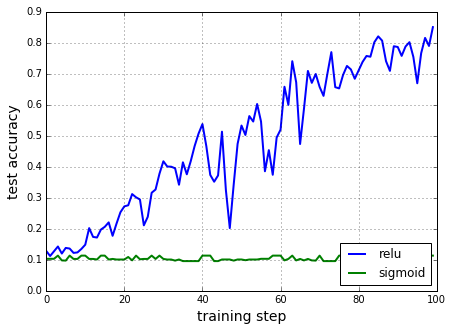

In [39]:
figsize(7,5)
for m in accs:
    plt.plot(accs[m], lw=2, label=m)
plt.xlabel("training step", fontsize=14)
plt.ylabel("test accuracy", fontsize=14)
plt.legend(loc="lower right")
plt.grid("on");

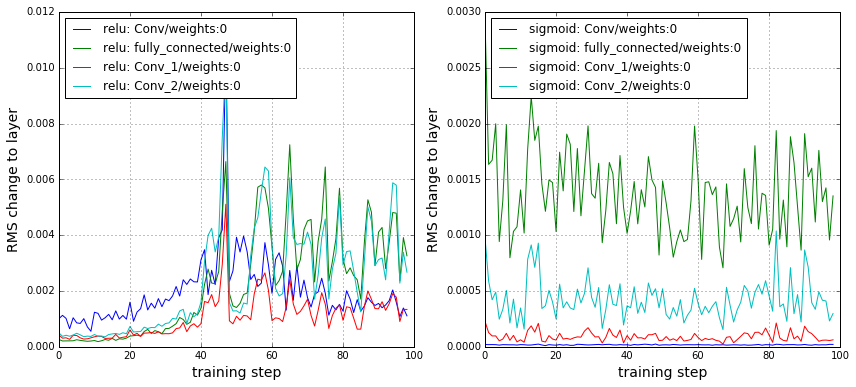

In [43]:
figsize(14,6)
i = 1
for m in weightdiffs:
    plt.subplot(1,2,i)
    for w in weightdiffs[m]:
        plt.plot(weightdiffs[m][w], label="%s: %s"%(m,w))
    plt.grid("on")
    plt.xlabel("training step", fontsize=14)
    plt.ylabel("RMS change to layer", fontsize=14)
    plt.legend(loc="upper left")
    i += 1